In [ ]:
!pip install hdbscan
!pip install umap-learn

In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import umap
import copy
from collections import Counter
pd.options.display.latex.repr = True

/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataset_detail(dataset_name):
    feature_vector = np.load(f'../npy/{dataset_name}-x.npy')
    dataset_labels = np.load(f'../npy/{dataset_name}-y.npy', allow_pickle=True)
    activity_mapping = np.load(f'../npy/{dataset_name}-labels.npy', allow_pickle=True)
    return feature_vector, dataset_labels, activity_mapping
feature_vector, dataset_labels, mapping = get_dataset_detail('hh102-ori')

In [3]:
manual_mapping = {"Cook_Breakfast": "Cook",
                              "Cook_Lunch": "Cook",
                              "Cook_Dinner": "Cook",
                              "Eat_Breakfast": "Eat",
                              "Eat_Lunch": "Eat",
                              "Eat_Dinner": "Eat",
                              "Morning_Meds": "Take_Medicine",
                              "Evening_Meds": "Take_Medicine",
                              "Wash_Breakfast_Dishes": "Wash_Dishes",
                              "Wash_Lunch_Dishes": "Wash_Dishes",
                              "Wash_Dinner_Dishes": "Wash_Dishes",}
manual_mapping = {"Cook_Breakfast": "Cook",
                              "Cook_Lunch": "Cook",
                              "Cook_Dinner": "Cook",
                              "Eat_Breakfast": "Eat",
                              "Eat_Lunch": "Eat",
                              "Eat_Dinner": "Eat",
                              "Morning_Meds": "Take_Medicine",
                              "Evening_Meds": "Take_Medicine",
                              "Wash_Breakfast_Dishes": "Wash_Dishes",
                              "Wash_Lunch_Dishes": "Wash_Dishes",
                              "Wash_Dinner_Dishes": "Wash_Dishes",
                              "Work_At_Table": "Work",
                              "Watch_TV": "Relax",
                              "Read": "Work",
                              "Entertain_Guests": "Relax",
                              "Sleep_Out_Of_Bed": "Relax",
                              "Step_Out": "Leave_Home",}
# manual_mapping = None

In [4]:
pd.DataFrame.from_dict(manual_mapping, orient='index', columns=['Mapped to']).reset_index().rename(columns={'index':'Original Activity'})

,Original Activity,Mapped to
0,Cook_Breakfast,Cook
1,Cook_Lunch,Cook
2,Cook_Dinner,Cook
3,Eat_Breakfast,Eat
4,Eat_Lunch,Eat
5,Eat_Dinner,Eat
6,Morning_Meds,Take_Medicine
7,Evening_Meds,Take_Medicine
8,Wash_Breakfast_Dishes,Wash_Dishes
9,Wash_Lunch_Dishes,Wash_Dishes


In [8]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
def get_activity_df(feature_vectors, labels, activity_mapping, manual_mapping=None):
    df = pd.DataFrame(feature_vectors)
    inverse_activity_mapping = {v :k for k, v in activity_mapping.items()}
    labels = [inverse_activity_mapping[label] for label in labels]
    if manual_mapping:
        labels = [label if label not in manual_mapping else manual_mapping[label] for label in labels]
    df['Label'] = labels
    if 'Other_Activity' in labels:
        df = df[df['Label'] != 'Other_Activity']
        
    return df

def visualize_clustering_activities(activities, feature_vectors, labels, activity_mapping, manual_mapping=None, dim_reducer=umap.UMAP()):
    for act in activities:
        if act not in activity_mapping:
            print(f'{act} can\'t be found inside the activity mapping, Please double check!')
            return
    df = get_activity_df(feature_vectors, labels, activity_mapping, manual_mapping)

    df = df[df['Label'].apply(lambda x : x in activities)]
    filtered_labels = np.array(df['Label'])
    df = df.drop(columns=['Label'])

    scaled_data = StandardScaler().fit_transform(df)
    embedding = dim_reducer.fit_transform(scaled_data)
    color_mapping = sns.color_palette("tab10", len(activities))

    f, ax = plt.subplots(figsize=(15, 12))

    for i, act in enumerate(activities):
        activity_feature_idx = np.where(filtered_labels == act)
        ax.scatter(embedding[activity_feature_idx, 0], embedding[activity_feature_idx, 1], color=color_mapping[i], label=act)
    ax.legend()
    plt.legend(prop={'size': 20})
    return ax

In [17]:
fib_feature = np.load('../hh_dataset/hh_npy/hh102_feature.npy')
fib_activity = np.load('../hh_dataset/hh_npy/hh102_activity.npy')
def preprocess_features(features, method) -> np.ndarray:
    if method not in ['mean', 'mean_std', 'mean_with_weight', 'mean_std_max_min']:
        raise ValueError('Please double check the method parameter')

    preprocessed_features = np.array([])
    if method == 'mean':
        return features.mean(axis=1)
    elif method == 'mean_std':
        preprocess_features = np.array(features.mean(axis=1))
        print(preprocess_features.shape)
        preprocess_features = np.concatenate([preprocess_features, features.std(axis=1)], axis=1)
        print(preprocess_features.shape)
        return preprocess_features
    elif method == 'mean_with_weight':
        out = []
        for instance in features:
            out.append(np.sum([vector*((i+1)/len(instance)) for i, vector in enumerate(instance)], axis=0))
        return np.array(out)
    return np.array([])
fib_feature = preprocess_features(fib_feature, 'mean_with_weight')

activity_mapping = {'Sleep': 0,
 'Bed_Toilet_Transition': 1,
 'Toilet': 2,
 'Take_Medicine': 3,
 'Dress': 4,
 'Work': 5,
 'Cook': 6,
 'Eat': 7,
 'Wash_Dishes': 8,
 'Relax': 9,
 'Personal_Hygiene': 10,
 'Bathe': 11,
 'Groom': 12,
 'Drink': 13,
 'Leave_Home': 14,
 'Enter_Home': 15,
 'Phone': 16,
 'Other_Activity': 17}

# Plotting the scatter plot
activities_plot = ['Drink', 'Phone']
# for i, activity in enumerate(activities_plot):
#     activity_vector = np.zeros(len(activity2id)-1)
#     activity_index = [i for i, act in enumerate(activities) if (act[activity2id[activity]] == 1)]
#     activity_feature_vector = np.array([feature for i, feature in enumerate(features) if i in activity_index])

#     print(f'{activity}: shape{activity_feature_vector.shape}')
#     instance, _, _ = activity_feature_vector.shape
#     sleep_feature_vectors = activity_feature_vector.reshape((instance, -1))

#     dim_reducer=umap.UMAP()
#     scaled_data = StandardScaler().fit_transform(sleep_feature_vectors)
#     embedding = dim_reducer.fit_transform(scaled_data)
#     color_mapping = sns.color_palette("tab10", len(activities))

#     plt.scatter(embedding[:, 0], embedding[:, 1], color=color_mapping[i], label=activity)
# plt.legend()
visualize_clustering_activities(activities_plot, fib_feature, fib_activity, activity_mapping)


TypeError: unhashable type: 'numpy.ndarray'

In [7]:
import json
fib_feature = np.load('../hh_dataset/hh_npy/hh102_feature.npy')
fib_activity = np.load('../hh_dataset/hh_npy/hh102_activity.npy')
def preprocess_features(features, method) -> np.ndarray:
    if method not in ['mean', 'mean_std', 'mean_with_weight', 'mean_std_max_min']:
        raise ValueError('Please double check the method parameter')

    preprocessed_features = np.array([])
    if method == 'mean':
        return features.mean(axis=1)
    elif method == 'mean_std':
        preprocess_features = np.array(features.mean(axis=1))
        print(preprocess_features.shape)
        preprocess_features = np.concatenate([preprocess_features, features.std(axis=1)], axis=1)
        print(preprocess_features.shape)
        return preprocess_features
    elif method == 'mean_with_weight':
        out = []
        for instance in features:
            out.append(np.sum([vector*((i+1)/len(instance)) for i, vector in enumerate(instance)], axis=0))
        return np.array(out)
    return np.array([])
fib_feature = preprocess_features(fib_feature, 'mean_with_weight')
with open('../hh_dataset/hh_npy/fib_hh102_mapping.json', 'r') as f:
    mapping = json.load(f)
activities = np.zeros((fib_activity.shape[0],))
# timeframed_dataset[start_time: start_time+delta]
## TODO!!!!! Add weights when finding the most frequent activity inside timewindow
for i in range(fib_activity.shape[0]):
    activity_within_range = fib_activity[i]
    time_window_activity_count = dict(Counter(activity_within_range[activity_within_range != 'Other_Activity']))
    most_common = [(k, v*activity_weight[k]) for k, v in time_window_activity_count.items()]
    
    if len(most_common) > 0:
        activities[i] = mapping[max(most_common, key=lambda x:x[1])[0]]

activities

/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


TypeError: unhashable type: 'numpy.ndarray'

### Apply Agglomerative clustering

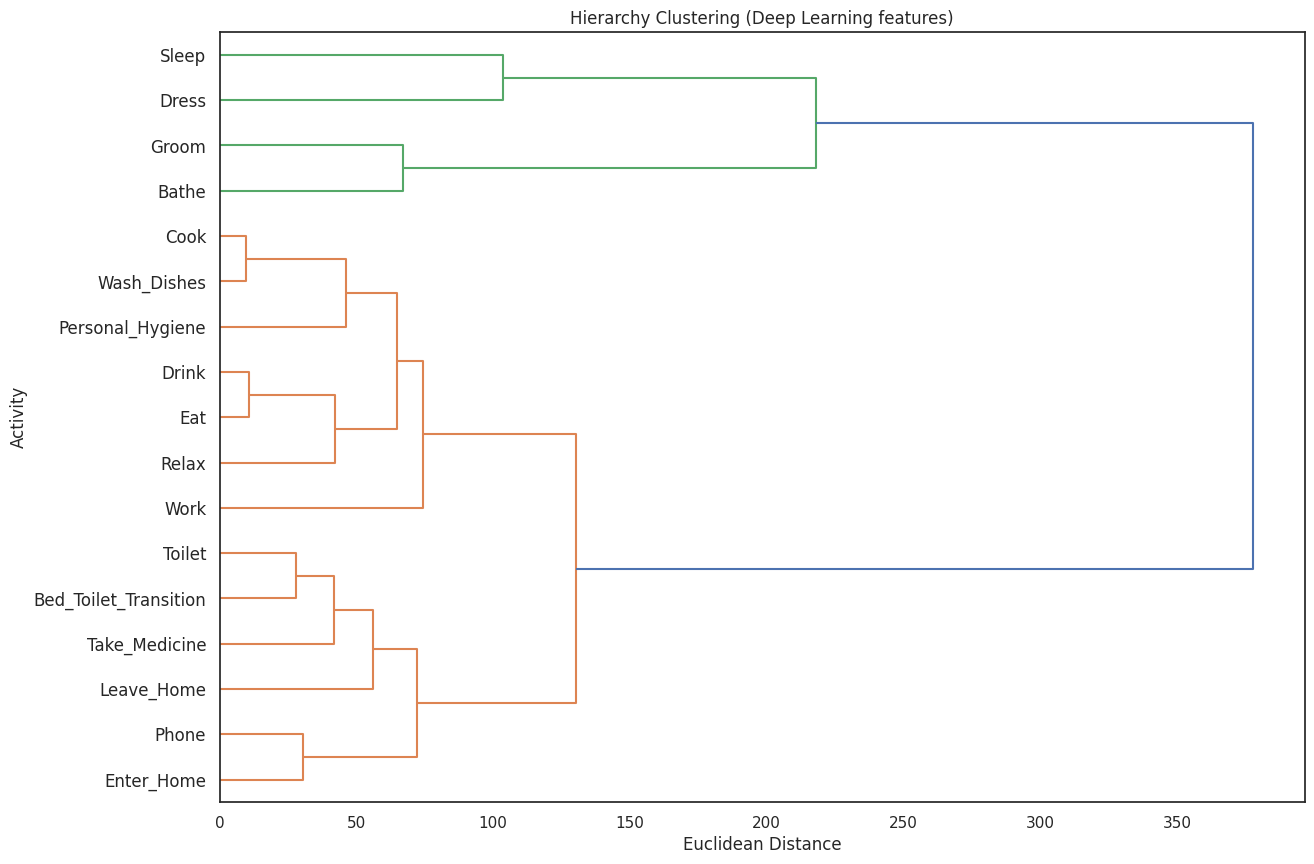

In [7]:
# Agglomerative clustering on one-hot encoding data, focused on the sequence of sensors triggered
# manual_mapping=None
df = get_activity_df(feature_vector, dataset_labels, mapping.item(), manual_mapping)

labels = df['Label']

activity_df = [df[df['Label'] == label] for label in set(labels)]
activity_bar = [(df['Label'].iloc[0], np.array(df.drop(columns=['Label']).mean())) for df in activity_df]

activity_data = [i[1] for i in activity_bar]
labels = [i[0] for i in activity_bar]
linkage_data = linkage(activity_data, method='ward', metric='euclidean')
dendrogram(linkage_data, labels=labels, orientation='right')

plt.ylabel('Activity')
plt.xlabel('Euclidean Distance')
plt.title('Hierarchy Clustering (Deep Learning features)')
plt.savefig('./figure/hierarchy_clustering_raw_before_mapping.png', dpi=150, bbox_inches="tight")
plt.show()

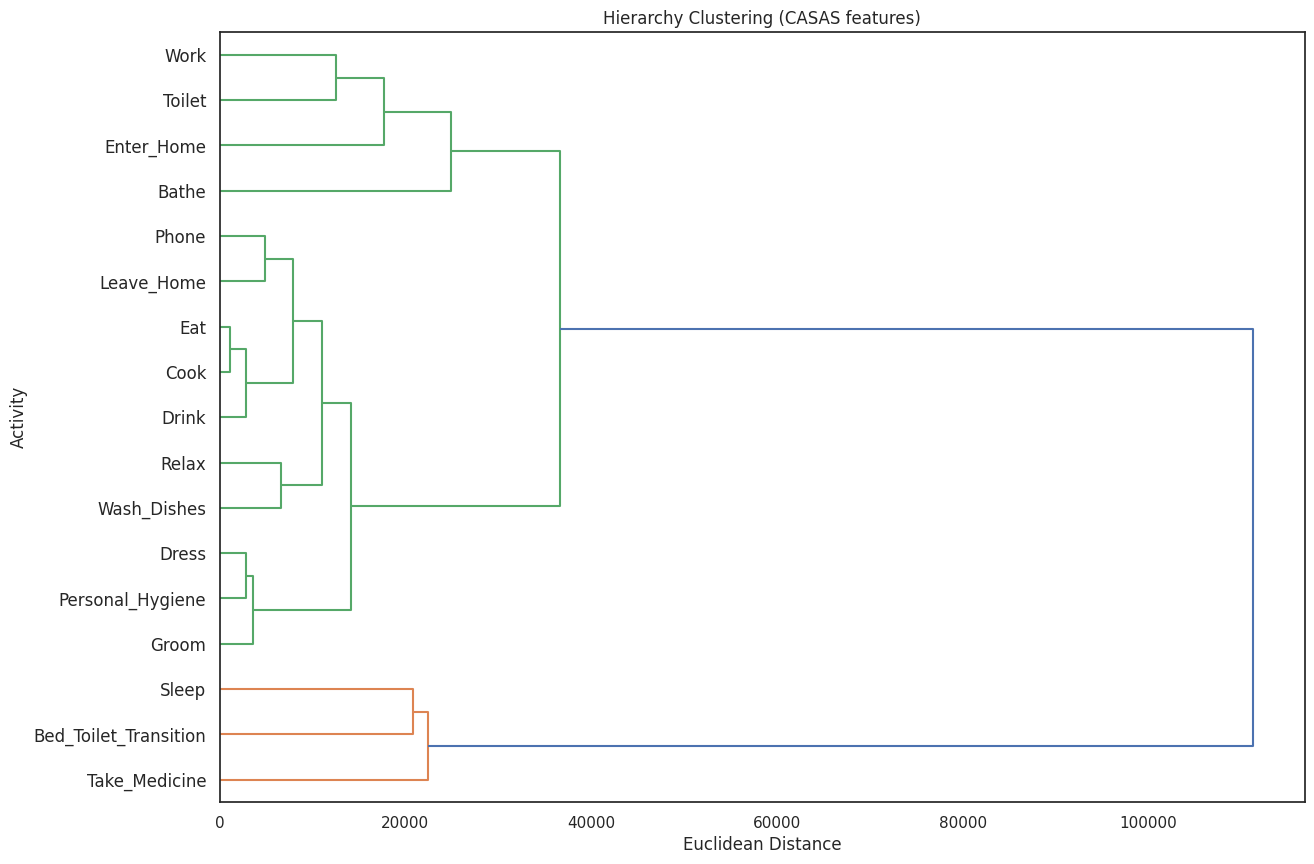

In [11]:
# Agglomerative clustering on temproal data, focused on the elapsed time for sensor data
feature_df = pd.read_csv('../hh_dataset/hh102/hh102.ann.features.csv')

feature_df = feature_df[feature_df['activity'] != 'Other_Activity']

labels = feature_df['activity']

if manual_mapping:
    labels = [label if label not in manual_mapping else manual_mapping[label] for label in labels]
    feature_df['activity'] = labels
    
activity_df = [feature_df[feature_df['activity'] == label] for label in set(labels)]
activity_bar = [(df['activity'].iloc[0], np.array(df.drop(columns=['activity']).mean())) for df in activity_df]

activity_data = [i[1] for i in activity_bar]
labels = [i[0] for i in activity_bar]
linkage_data = linkage(activity_data, method='ward', metric='euclidean')
dendrogram(linkage_data, labels=labels, orientation='right')

plt.ylabel('Activity')
plt.xlabel('Euclidean Distance')
plt.title('Hierarchy Clustering (CASAS features)')
plt.savefig('./figure/hierarchy_clustering_casas.png', dpi=150, bbox_inches="tight")
plt.show()

In [10]:
feature_df.columns

Index(['lastSensorEventHours', 'lastSensorEventSeconds', 'lastSensorDayOfWeek',
       'windowDuration', 'timeSinceLastSensorEvent', 'prevDominantSensor1',
       'prevDominantSensor2', 'lastSensorID', 'lastSensorLocation',
       'lastMotionLocation', 'complexity', 'activityChange', 'areaTransitions',
       'numDistinctSensors', 'sensorCount-Bathroom', 'sensorCount-Bedroom',
       'sensorCount-Chair', 'sensorCount-DiningRoom', 'sensorCount-Hall',
       'sensorCount-Ignore', 'sensorCount-Kitchen', 'sensorCount-LivingRoom',
       'sensorCount-Office', 'sensorCount-OutsideDoor', 'sensorCount-WorkArea',
       'sensorElTime-Bathroom', 'sensorElTime-Bedroom', 'sensorElTime-Chair',
       'sensorElTime-DiningRoom', 'sensorElTime-Hall', 'sensorElTime-Ignore',
       'sensorElTime-Kitchen', 'sensorElTime-LivingRoom',
       'sensorElTime-Office', 'sensorElTime-OutsideDoor',
       'sensorElTime-WorkArea', 'activity'],
      dtype='object')

The clustering graph shows the agglomerative clustering on each activities vector by averaging its vectors appeared provided on the dataset; as shown, the feature extracted for RNN model, are hard for normal ML models to learn enough to classify different between activities. This are likely that the features doesn't include any temporal information, but relies on the RNN structure to learn the input.

In [11]:
feature_df.head()

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,...,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea,activity
4,3.0,13124.0,2.0,58.0,3.0,0.0,0.0,0.0,0.0,0.0,...,86400.0,86400.0,86400.0,11622.589618,86400.0,86400.0,86400.0,86400.0,86400.0,Bed_Toilet_Transition
6,3.0,13127.0,2.0,36.0,2.0,0.0,0.0,0.0,0.0,0.0,...,86400.0,86400.0,86400.0,11625.752047,86400.0,86400.0,86400.0,86400.0,86400.0,Bed_Toilet_Transition
7,3.0,13128.0,2.0,37.0,1.0,0.0,0.0,0.0,0.0,0.0,...,86400.0,86400.0,86400.0,11626.336230,86400.0,86400.0,86400.0,86400.0,86400.0,Bed_Toilet_Transition
8,3.0,13131.0,2.0,39.0,3.0,0.0,0.0,0.0,0.0,0.0,...,86400.0,86400.0,86400.0,11629.317838,86400.0,86400.0,86400.0,86400.0,86400.0,Bed_Toilet_Transition
9,3.0,13132.0,2.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,...,86400.0,86400.0,86400.0,11630.478813,86400.0,86400.0,86400.0,86400.0,86400.0,Bed_Toilet_Transition


In [12]:
rf_feature_vectors_label = feature_df['activity']
rf_feature_vectors_df = feature_df.drop(columns=['activity'])

# Create an identify dictionary, just to make things consistent
dummy_mapping = {k:k for k in rf_feature_vectors_label}

ax=visualize_clustering_activities(['Cook', 'Drink', 'Sleep'], rf_feature_vectors_df, rf_feature_vectors_label, dummy_mapping)
# plt.title('Visualization on Manually Extracted Feature with Annotated Activities', fontsize=15)
ax

KeyboardInterrupt: 

### Perform the DBSCAN

In [ ]:
db = DBSCAN(eps=1.0, min_samples=2, n_jobs=-1).fit(feature_vector)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset_labels, labels))
print("Completeness: %0.3f" % metrics.completeness_score(dataset_labels, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(dataset_labels, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(dataset_labels, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(dataset_labels, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(feature_vector, labels))

### Performing K-mean clustering

In [ ]:
# Apply the k-mean directly on the raw data
kmeans = KMeans(n_clusters=len(mapping.item()), random_state=0).fit(feature_vector)
labels = kmeans.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset_labels, labels))
print("Completeness: %0.3f" % metrics.completeness_score(dataset_labels, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(dataset_labels, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(dataset_labels, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(dataset_labels, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(feature_vector, labels))

In [ ]:
activity_occurence = dict(Counter(df['Label']).items())
{k: v for k, v in sorted(activity_occurence.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
# Apply K-means on certain activities data, and deduce which activities are closer
activities = ['Sleep', 'Relax']
sleep_or_relax_activity = df[df['Label'].apply(lambda x: x in activities)]
sleep_or_relax_labels = sleep_or_relax_activity['Label']
sleep_or_relax_activity = sleep_or_relax_activity.drop(columns=['Label'])

sleep_out_of_bed_activity = df[df['Label'] == 'Sleep_Out_Of_Bed'].drop(columns=['Label'])

kmeans = KMeans(n_clusters=2, random_state=0).fit(sleep_or_relax_activity)
# kmeans.predict(sleep_out_of_bed_activity)
labels = kmeans.labels_

dataset_labels = sleep_or_relax_labels

print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset_labels, labels))
print("Completeness: %0.3f" % metrics.completeness_score(dataset_labels, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(dataset_labels, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(dataset_labels, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(dataset_labels, labels)
)
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(feature_vector, labels))

In [ ]:
# Perform a UMAP dim-reducer before doing the K-Mean clustering
df = get_activity_df(feature_vector, dataset_labels, mapping.item(), manual_mapping)

# df = df[df['Label'].apply(lambda x : x in activities)]
df_out = copy.deepcopy(df)
filtered_labels = np.array(df['Label'])
df = df.drop(columns=['Label'])

In [ ]:
metrics_result = {}
max_n_component = 0
max_metrics_v = 0
for n_component in [1, 2, 5, 10, 20]:
    dim_reducer = umap.UMAP(n_components=n_component)

    scaled_data = StandardScaler().fit_transform(df)
    embedding = dim_reducer.fit_transform(scaled_data)

    kmeans = KMeans(n_clusters=len(set(filtered_labels)), random_state=0).fit(embedding)
    labels = kmeans.labels_
    
    if metrics.v_measure_score(filtered_labels, labels) > max_metrics_v:
        max_n_component = n_component
        max_metrics_v = metrics.v_measure_score(filtered_labels, labels)
        
    metrics_result[n_component] = [metrics.homogeneity_score(filtered_labels, labels),
                                  metrics.completeness_score(filtered_labels, labels),
                                  metrics.v_measure_score(filtered_labels, labels),
                                  metrics.adjusted_rand_score(filtered_labels, labels),
                                  metrics.adjusted_mutual_info_score(filtered_labels, labels),
                                  metrics.silhouette_score(scaled_data, labels)]\
    
homo, complete, v_measure, rand_score, mutual_info, silh_score = metrics_result[max_n_component]
    
print(f"For dimension {max_n_component}")
print("Homogeneity: %0.3f" % homo)
print("Completeness: %0.3f" % complete)
print("V-measure: %0.3f" % v_measure)
print("Adjusted Rand Index: %0.3f" % rand_score)
print(
    "Adjusted Mutual Information: %0.3f"
    % mutual_info
)
print("Silhouette Coefficient: %0.3f" % silh_score)

### Conclusion for K-mean
Using K-mean++ can't even partition the activity vector 'Sleep' and 'Relax', which show a good separation at UMAP. Therefore, K-Mean++ may not be a wise choice for the purpose on identifying similar activities.

In [ ]:
db = DBSCAN(eps=1.0, min_samples=2, n_jobs=-1).fit(sleep_or_relax_activity)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(sleep_or_relax_labels)) - (1 if -1 in labels else 0)
n_noise_ = list(sleep_or_relax_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(dataset_labels, labels))
print("Completeness: %0.3f" % metrics.completeness_score(dataset_labels, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(dataset_labels, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(dataset_labels, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(dataset_labels, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(feature_vector, labels))

### Reduce dimensionality

In [27]:
import sys
import numpy as np

datasetName = 'hh102'

X = np.load('../npy/' + datasetName + '-x.npy', allow_pickle=True)
Y = np.load('../npy/' + datasetName + '-y.npy', allow_pickle=True)

dictActivities = np.load('../npy/' + datasetName + '-labels.npy', allow_pickle=True).item()

Text(0.5, 1.0, 'Visualization on One-Hot Encoded Feature with Annotated Activities')

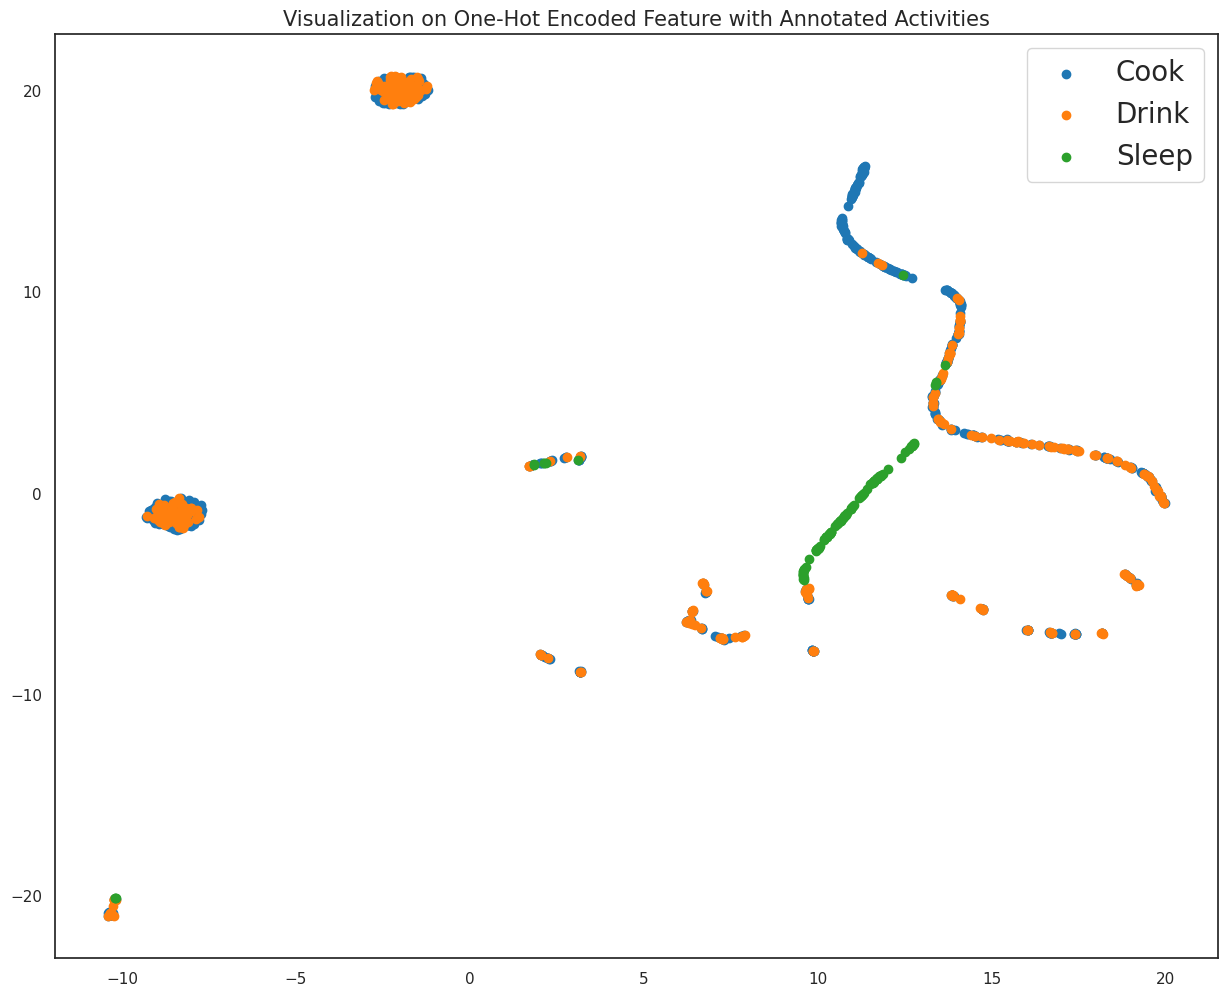

In [30]:
scaled_data = StandardScaler().fit_transform(X)

ax=visualize_clustering_activities(['Cook', 'Drink', 'Sleep'], scaled_data, Y, dictActivities)
plt.title('Visualization on One-Hot Encoded Feature with Annotated Activities', fontsize=15)

In [15]:
scaled_data = StandardScaler().fit_transform(X)
embedding = umap.UMAP(n_components=1000).fit_transform(scaled_data)

embedding.shape

KeyboardInterrupt: 

In [ ]:
datasetName = 'hh102-umap'
np.save('../npy/' + datasetName + '-x.npy', embedding)
np.save('../npy/' + datasetName + '-y.npy', Y)
np.save('../npy/' + datasetName + '-labels.npy', dictActivities)

In [ ]:
embedding.shape

In [ ]:
X.shape